In [1]:
from pathlib import Path
import shutil
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage.io import imread
from PIL import Image
from src.model import FusionNet
import torchvision.transforms as T
import torch.nn.functional as F

MODEL_PATH  = Path("fusion_model.pth") 
TEST_IMAGE = Path("2496338_1117313.tif")
DATA_SPLIT = Path("dataset_split.csv")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
if not MODEL_PATH.exists():
    print(f"[ERROR] {MODEL_PATH} not found")

if not TEST_IMAGE.exists():
    print(f"[ERROR] {TEST_IMAGE} not found (expected in same directory as inference.ipynb)")

if not DATA_SPLIT.exists():
    print(f"[ERROR] {DATA_SPLIT} not found (expected in same directory as inference.ipynb)")

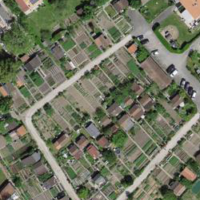

In [3]:
arr = imread(TEST_IMAGE)

# Normalize image
arr = (arr - arr.min()) / (arr.max() - arr.min())
arr = (arr * 255).astype(np.uint8)

img = Image.fromarray(arr, mode="RGB")
img

In [4]:
transform = T.Compose([
    T.ToTensor(),
])
image_tensor = transform(img).unsqueeze(0).to(DEVICE)
print("image_tensor:", image_tensor.shape)

image_tensor: torch.Size([1, 3, 200, 200])


In [5]:
df = pd.read_csv(DATA_SPLIT)

sample_id = TEST_IMAGE.stem
print("sample_id:", sample_id)

matches = df[df["id"] == str(sample_id)]

if len(matches) == 0:
    raise ValueError(f"No CSV row found with id == {sample_id}")
if len(matches) > 1:
    print("Warning: multiple rows match this id; using the first one.")

row = matches.iloc[0]
print("Found row split:", row.get("split"))
print("Label cls:", row.get("EUNIS_cls"), "Label name:", row.get("EUNIS_label"))

sample_id: 2496338_1117313
Found row split: test
Label cls: 13 Label name: Cultivated areas of gardens and parks


In [6]:
meta_cols = {"id", "id_str", "x", "y", "split", "EUNIS_cls", "EUNIS_label"}
var_cols = [c for c in df.columns if c not in meta_cols]

variables_np = row[var_cols].astype(float).values.astype(np.float32)
variables = torch.tensor(variables_np, dtype=torch.float32).unsqueeze(0).to(DEVICE)

print("Variables dim:", variables.shape)

Variables dim: torch.Size([1, 52])


In [7]:
var_input_dim = None if variables is None else variables.shape[1]
print("var_input_dim:", var_input_dim)

model = FusionNet(
    num_classes=17,
    var_input_dim=var_input_dim,
    var_hidden_dim=256,
    dropout=0.5
).to(DEVICE)

state_dict = torch.load(MODEL_PATH, map_location=DEVICE)

state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}

model.load_state_dict(state_dict)
model.eval()
print("Loaded model")

var_input_dim: 52
Loaded model


In [8]:
eunis_id_to_lab = {
    0: 'Surface standing waters',
    1: 'Surface running waters',
    2: 'Dry grasslands',
    3: 'Mesic grasslands',
    4: 'Seasonally wet and wet grasslands',
    5: 'Alpine and subalpine grasslands',
    6: 'Arctic, alpine and subalpine scrub',
    7: 'Shrub plantations',
    8: 'Broadleaved deciduous woodland',
    9: 'Coniferous woodland',
    10: 'Mixed deciduous and coniferous woodland',
    11: 'Inland cliffs, rock pavements and outcrops',
    12: 'Arable land and market gardens',
    13: 'Cultivated areas of gardens and parks',
    14: 'Buildings of cities, towns and villages',
    15: 'Low density buildings',
    16: 'Transport networks and other constructed hard-surfaced areas'}

In [9]:
with torch.no_grad():
    logits = model(image_tensor, variables)
    probs = F.softmax(logits, dim=1)[0].detach().cpu()

topk = min(5, probs.numel())
vals, idx = torch.topk(probs, topk)

print("True class:", int(row["EUNIS_cls"]), str(row["EUNIS_label"]))
print("Top predictions:")
for p, i in zip(vals.tolist(), idx.tolist()):
    print(f"{i}) {eunis_id_to_lab[i]}: {p:.4f}")

True class: 13 Cultivated areas of gardens and parks
Top predictions:
13) Cultivated areas of gardens and parks: 0.4209
5) Alpine and subalpine grasslands: 0.0794
14) Buildings of cities, towns and villages: 0.0613
6) Arctic, alpine and subalpine scrub: 0.0541
9) Coniferous woodland: 0.0521
